In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [13]:
import sklearn.datasets

In [44]:
numeros = sklearn.datasets.load_digits()
imagenes = numeros['images']  # Hay 1797 digitos representados en imagenes 8x8
n_imagenes = len(imagenes)
X = imagenes.reshape((n_imagenes, -1)) # para volver a tener los datos como imagen basta hacer data.reshape((n_imagenes, 8, 8))
#X=imagenes
Y = numeros['target']
print(np.shape(X), np.shape(Y))
print(Y[:10])

(1797, 64) (1797,)
[0 1 2 3 4 5 6 7 8 9]


In [45]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.5)

In [63]:
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = (scaler.transform(X_test))
#conversion to pytorch tensor and adding a 1 dimension with unsqueeze
X_train_t = torch.from_numpy(X_train.reshape((len(X_train), 8, 8))).unsqueeze(1)
X_test_t = torch.from_numpy(X_test.reshape((len(X_test), 8, 8))).unsqueeze(1)

In [67]:
print(np.shape(X_train_t[0]))
print(X_train_t.size())

torch.Size([1, 8, 8])
torch.Size([898, 1, 8, 8])


(898, 64)


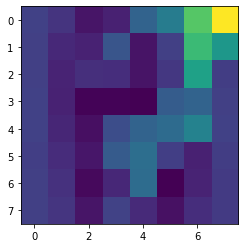

In [68]:
print(np.shape(X_train))
plt.imshow(X_train.reshape((898, 8, 8))[0])

In [78]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=8, stride=3),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(1,7,kernel_size=4),
            torch.nn.ReLU(True))
        self.decoder = torch.nn.Sequential(             
            torch.nn.ConvTranspose2d(7,1,kernel_size=4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(1,1,kernel_size=10, stride=3),
            torch.nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [79]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1E-3)

In [81]:
# entrenamiento
for epoch in range(num_epochs):
    output = model(X_train_t[:2])
    loss = distance(output, X_train_t[:2])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #3 'mat1' in call to _th_addmm_